In [2]:
##################
# IMPORT LIBRARIES
##################

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from pandas.tseries.offsets import Week

In [3]:
##################
# VISUAL SETTINGS
##################

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

In [4]:
##################
# LOADING CSV
##################

# Toggle this flag to True in production
RENAME_FILES = False

data_dir = 'data'

# List and sort files by creation time
files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if os.path.isfile(os.path.join(data_dir, f)) and f.endswith('.csv')
]

sorted_files = sorted(files, key=os.path.getctime, reverse=True)

# Loop over files
for file_path in sorted_files:
    created_at = datetime.fromtimestamp(os.path.getctime(file_path))
    timestamp_str = created_at.strftime('%Y-%m-%d_%H-%M-%S')
    original_name = os.path.basename(file_path)
    new_name = f"{timestamp_str}_{original_name}"
    new_path = os.path.join(data_dir, new_name)

    if RENAME_FILES:
        if not original_name.startswith(timestamp_str):
            os.rename(file_path, new_path)
            print(f"Renamed: {original_name} → {new_name}")
            file_path = new_path
        else:
            print(f"Already renamed: {original_name}")
    else:
        print(f"[DEV] Would rename: {original_name} → {new_name}")



df_raw = pd.read_csv(file_path)

[DEV] Would rename: DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv → 2025-05-27_20-40-12_DishpatchSubscriptionData_NIklas_Sanitised - subscriptions (2).csv


/var/folders/2c/jlpbrr154jg9cfp1pzbh8x5h0000gn/T/ipykernel_12722/2434652292.py:39: DtypeWarning: Columns (2,21,30,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(file_path)


In [5]:
df = df_raw.copy()

# Date conversion
date_cols = [col for col in df.columns if '(UTC)' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Order by Created (UTC)
df = df.sort_values(by='Created (UTC)')


In [6]:
df.columns

Index(['id', 'Customer ID', 'Customer Description', 'Customer Name', 'Plan',
       'Product', 'Product ID', 'Quantity', 'Currency', 'Cancellation Reason',
       'Interval', 'Amount', 'Status', 'Created (UTC)', 'Start (UTC)',
       'Start Date (UTC)', 'Current Period Start (UTC)',
       'Current Period End (UTC)', 'Trial Start (UTC)', 'Trial End (UTC)',
       'Application Fee Percent', 'Coupon', 'Tax Percent', 'Canceled At (UTC)',
       'Cancel At Period End', 'Ended At (UTC)', 'Exclusive Tax Rate',
       'Inclusive Tax Rate', 'Automatic Tax Enabled',
       'Tax Location Recognized', 'kind (metadata)',
       'senderShopifyCustomerId (metadata)', 'shopifyCustomerId (metadata)',
       'previousEndDate (metadata)'],
      dtype='object')

In [7]:
reference_date = datetime.now()
df = df[['id', 
        'Customer ID',
        'Customer Name',
        'Status',
        'Cancellation Reason',
        'Created (UTC)',
        'Start (UTC)',
        'Start Date (UTC)',
        'Current Period Start (UTC)',
        'Current Period End (UTC)',
        'Trial Start (UTC)',
        'Trial End (UTC)',
        'Canceled At (UTC)',
        'Ended At (UTC)',
       'senderShopifyCustomerId (metadata)']]

df.rename(columns={'Customer ID' : 'customer_id',
                   'Status' : 'status',
                   'Created (UTC)': 'created_at',
                   'Start (UTC)': 'start_at',
                   'Start Date (UTC)': 'start_date',
                   'Current Period Start (UTC)': 'current_period_start',
                   'Current Period End (UTC)': 'current_period_end',
                   'Trial Start (UTC)': 'trial_start',
                   'Trial End (UTC)': 'trial_end',
                   'Canceled At (UTC)': 'canceled_at',
                   'Ended At (UTC)': 'ended_at',
                   'senderShopifyCustomerId (metadata)': 'gifted'
                }, inplace=True)

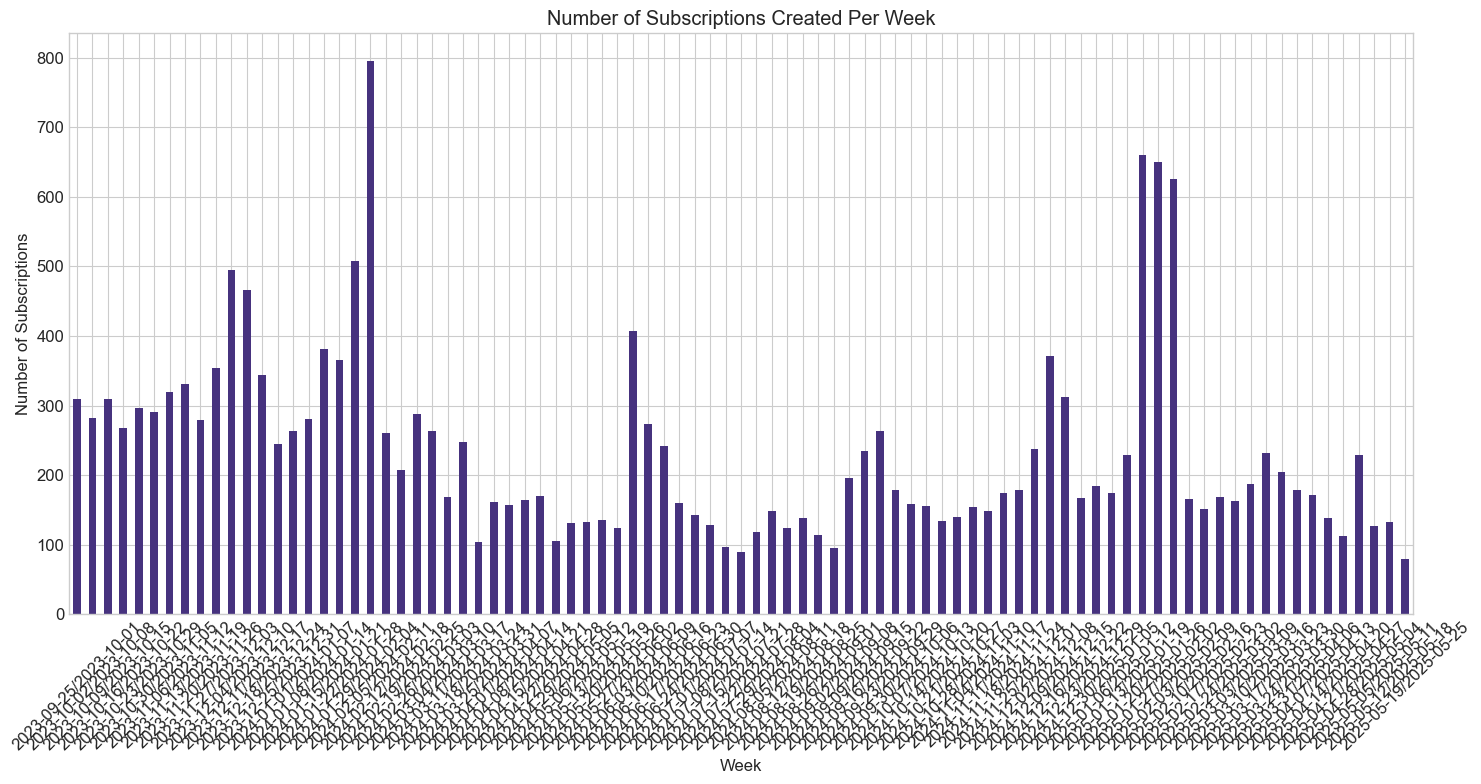

In [8]:
# plt.figure(figsize=(15,8))
# df['created_at'].plot(title='Subscriptions Created Over Time')
# plt.xlabel('Index')
# plt.ylabel('Creation Date')

# Group subscriptions by week and plot
df['week'] = pd.to_datetime(df['created_at']).dt.to_period('W')
weekly_counts = df.groupby('week').size()

plt.figure(figsize=(15,8))
weekly_counts.plot(kind='bar')
plt.title('Number of Subscriptions Created Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Subscriptions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [9]:

#df['yearly_subscription'] = (df['current_period_end'] - df['current_period_start']).dt.days >= 365
#df['trial-time'] = (df['trial_end'] - df['trial_start']).dt.days
df['period_duration'] = np.where(df['ended_at'].notnull(),
                            (df['ended_at'] - df['current_period_start']),
                            (df['current_period_end'] - df['current_period_start']))

#df[df['status'] == 'active']

#df[df['customer_id'] == 'cus_OhfLGWZKdHkZrF']
#df[df['Customer Name'] == 'Customer17727']
#df[df['period_duration'] > 0].head(20)

#cus_OhagJTEOs7LZLk
#cus_Ohc4lazRKnDFZ3
#cus_OhdZKUNDUARcWt
#cus_Ohedmx3IFvbqdx
#cus_OnERK20W7y40xE
#cus_QHo0AQ9O78eogO 2 entry

#df[df['status'] == 'active']

df['customer_id'].value_counts()

df[df['customer_id'] == 'cus_QkwifqaTPO6I9J']

,id,customer_id,Customer Name,status,Cancellation Reason,created_at,start_at,start_date,current_period_start,current_period_end,trial_start,trial_end,canceled_at,ended_at,gifted,week,period_duration
8142,sub_1PxW49CZ9aYYH5wiYzsi3zuT,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-10 15:33:00,2024-09-10 15:33:00,2024-09-10 15:33:00,2024-09-10 15:33:00,2025-09-10 15:33:00,NaT,NaT,2024-09-11 13:17:00,2024-09-11 13:17:00,NaN,2024-09-09/2024-09-15,0 days 21:44:00
8121,sub_1PxqQoCZ9aYYH5wiwNmGG9yW,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-11 13:18:00,2024-09-11 13:18:00,2024-09-11 13:18:00,2024-09-11 13:18:00,2025-05-13 23:00:00,NaT,NaT,2024-09-11 13:26:00,2024-09-11 13:26:00,NaN,2024-09-09/2024-09-15,0 days 00:08:00
8118,sub_1PxqbCCZ9aYYH5wiH5KuXihZ,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-11 13:28:00,2024-09-11 13:28:00,2024-09-11 13:28:00,2024-09-11 13:28:00,2024-09-21 13:28:00,2024-09-11 13:28:00,2024-09-21 13:28:00,2024-09-11 13:32:00,2024-09-11 13:32:00,NaN,2024-09-09/2024-09-15,0 days 00:04:00
8117,sub_1PxqfOCZ9aYYH5wiJZFX00BB,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-11 13:33:00,2024-09-11 13:33:00,2024-09-11 13:33:00,2024-09-11 13:33:00,2025-03-11 00:00:00,NaT,NaT,2024-09-11 13:35:00,2024-09-11 13:35:00,NaN,2024-09-09/2024-09-15,0 days 00:02:00
8115,sub_1Pxqj8CZ9aYYH5wiUdbnqKVx,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-11 13:36:00,2024-09-11 13:36:00,2024-09-11 13:36:00,2024-09-11 13:36:00,2025-02-12 00:00:00,NaT,NaT,2024-09-11 13:41:00,2024-09-11 13:41:00,NaN,2024-09-09/2024-09-15,0 days 00:05:00
8116,sub_1PxqiHCZ9aYYH5wiv0ZnY8fm,cus_QkwifqaTPO6I9J,Customer5019,canceled,cancellation_requested,2024-09-11 13:36:00,2024-09-11 13:36:00,2024-09-11 13:36:00,2024-09-11 13:36:00,2025-02-13 00:00:00,NaT,NaT,2024-09-11 13:36:00,2024-09-11 13:36:00,NaN,2024-09-09/2024-09-15,0 days 00:00:00
8112,sub_1Pxqp3CZ9aYYH5wii6OStdTT,cus_QkwifqaTPO6I9J,Customer5019,canceled,payment_failed,2024-09-11 13:43:00,2024-09-11 13:43:00,2024-09-11 13:43:00,2024-09-11 23:00:00,2025-09-11 23:00:00,NaT,NaT,2024-10-03 00:03:00,2024-10-03 00:03:00,NaN,2024-09-09/2024-09-15,21 days 01:03:00


In [10]:
df[df['status'] == 'past_due']

,id,customer_id,Customer Name,status,Cancellation Reason,created_at,start_at,start_date,current_period_start,current_period_end,trial_start,trial_end,canceled_at,ended_at,gifted,week,period_duration
18578,sub_1O9sfECZ9aYYH5wiB0ItmFUE,cus_Oqz75bf2rklNAN,Customer16203,past_due,NaN,2023-11-07 17:02:00,2023-11-07 17:02:00,2023-11-07 17:02:00,2024-11-07 17:02:00,2025-11-07 17:02:00,NaT,NaT,NaT,NaT,NaN,2023-11-06/2023-11-12,365 days
16147,sub_1OQXrSCZ9aYYH5winDG3tgGe,cus_PF1qaufq8XNITm,Customer14155,past_due,NaN,2023-12-23 16:15:00,2023-12-23 16:15:00,2023-12-23 16:15:00,2024-12-23 16:15:00,2025-12-23 16:15:00,NaT,NaT,NaT,NaT,NaN,2023-12-18/2023-12-24,365 days
15667,sub_1OVELFCZ9aYYH5wiBiog3WgM,cus_PJs07ygcTcoAzs,Customer13761,past_due,NaN,2024-01-05 14:25:00,2024-01-05 14:25:00,2024-01-05 14:25:00,2025-01-05 14:25:00,2026-01-05 14:25:00,NaT,NaT,NaT,NaT,NaN,2024-01-01/2024-01-07,365 days
15647,sub_1OVbfnCZ9aYYH5wijkLAF18R,cus_PAX3mdFb9xVPsl,Customer13743,past_due,NaN,2024-01-06 15:20:00,2024-01-06 15:20:00,2024-01-06 15:20:00,2025-01-06 15:20:00,2026-01-06 15:20:00,NaT,NaT,NaT,NaT,NaN,2024-01-01/2024-01-07,365 days
15356,sub_1OYSBFCZ9aYYH5wiIxuh4C8d,cus_OnESCbTftXtWMk,Customer13510,past_due,NaN,2024-01-14 11:48:00,2024-01-14 11:48:00,2024-01-14 11:48:00,2025-01-14 11:48:00,2026-01-14 11:48:00,NaT,NaT,NaT,NaT,NaN,2024-01-08/2024-01-14,365 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,sub_1Pxt5KCZ9aYYH5wiaTsRq8IK,cus_OnERyWaGHaKiBD,Customer7352,past_due,NaN,2024-09-11 16:08:00,2024-09-11 16:08:00,2024-09-11 16:08:00,2025-05-11 23:00:00,2026-05-11 23:00:00,NaT,NaT,NaT,NaT,NaN,2024-09-09/2024-09-15,365 days
8042,sub_1PxtLGCZ9aYYH5wiavKFNGyA,cus_OnEPPiEHIFn2hk,Customer7338,past_due,NaN,2024-09-11 16:24:00,2024-09-11 16:24:00,2024-09-11 16:24:00,2025-05-05 23:00:00,2026-05-05 23:00:00,NaT,NaT,NaT,NaT,NaN,2024-09-09/2024-09-15,365 days
497,sub_1RJcjpCZ9aYYH5wiS1KI0WOu,cus_SE4tlsKTFhm7qO,Customer474,past_due,NaN,2025-04-30 15:39:00,2025-04-30 15:39:00,2025-04-30 15:39:00,2025-05-10 15:39:00,2026-05-10 15:39:00,2025-04-30 15:39:00,2025-05-10 15:39:00,NaT,NaT,NaN,2025-04-28/2025-05-04,365 days
309,sub_1RLoy5CZ9aYYH5wivDgmB2Nq,cus_SGLfs9645eKjTe,Customer299,past_due,NaN,2025-05-06 17:07:00,2025-05-06 17:07:00,2025-05-06 17:07:00,2025-05-16 17:07:00,2026-05-16 17:07:00,2025-05-06 17:07:00,2025-05-16 17:07:00,NaT,NaT,NaN,2025-05-05/2025-05-11,365 days


In [11]:
customer_df = df.groupby('customer_id').agg({
    'created_at': 'first',
    'status': 'last',
    'current_period_start': 'last',
    'current_period_end': 'last',
    'trial_start': 'first',
    'trial_end': 'last',
    'canceled_at': 'last',
    'ended_at': 'last',
    'gifted': list,
    'period_duration': sum
})








customer_df.loc[customer_df.index == 'cus_OhfLGWZKdHkZrF']
customer_df['period_duration'].value_counts().head(20)
customer_df[customer_df['trial_end'].isna()]

,created_at,status,current_period_start,current_period_end,trial_start,trial_end,canceled_at,ended_at,gifted,period_duration
customer_id,,,,,,,,,,
cus_OnEP03NV2sfijD,2024-09-11 16:29:00,active,2024-09-11 16:29:00,2025-07-28 23:00:00,NaT,NaT,NaT,NaT,[nan],320 days 06:31:00
cus_OnEP0E7ijO3Z6I,2024-09-11 16:26:00,active,2024-09-11 16:26:00,2025-08-11 23:00:00,NaT,NaT,NaT,NaT,[nan],334 days 06:34:00
cus_OnEP0JMOcOauwn,2024-09-11 16:28:00,canceled,2024-09-11 16:28:00,2025-05-08 23:00:00,NaT,NaT,2025-05-06 15:49:00,2025-05-08 23:00:00,[nan],239 days 06:32:00
cus_OnEP0h99S8YXIJ,2024-09-25 15:54:00,active,2024-09-25 15:54:00,2025-09-25 15:54:00,NaT,NaT,NaT,NaT,[nan],365 days 00:00:00
cus_OnEP1cB2kjFDgR,2024-09-25 16:02:00,active,2024-09-25 16:02:00,2025-09-25 16:02:00,NaT,NaT,NaT,NaT,[nan],365 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...
cus_SK4pCXYZZuwaeH,2025-05-16 15:59:00,active,2025-05-16 15:59:00,2026-05-16 15:59:00,NaT,NaT,2025-05-16 15:59:00,NaT,[6880407978026.0],365 days 00:00:00
cus_SK5m1zI3dksJhK,2025-05-16 16:59:00,active,2025-05-16 16:59:00,2026-05-16 16:59:00,NaT,NaT,2025-05-16 16:59:00,NaT,[3184448208938.0],365 days 00:00:00
cus_SKok7wMYgqrIT7,2025-05-18 15:26:00,active,2025-05-18 15:26:00,2026-05-18 15:26:00,NaT,NaT,2025-05-18 15:26:00,NaT,[23249636262272.0],365 days 00:00:00


In [12]:
df['Customer Name'].value_counts()

Customer5019     33
Customer8877     17
Customer2832     11
Customer13370    11
Customer2742      9
                 ..
Customer16739     1
Customer10765     1
Customer10764     1
Customer10763     1
Customer1         1
Name: Customer Name, Length: 17738, dtype: int64

In [13]:
customer_name_df = df.groupby('Customer Name').agg({
    'created_at': 'first',
    'status': 'last',
    'current_period_start': 'last',
    'current_period_end': 'last',
    'trial_start': 'first',
    'trial_end': 'last',
    'canceled_at': 'last',
    'ended_at': 'last',
    'gifted': list,
    'period_duration': sum
})

customer_name_df[customer_name_df['trial_end'].isna()]
customer_name_df
customer_name_df['period_duration'].value_counts().head(50)

365 days 00:00:00    5589
10 days 00:00:00     4742
366 days 00:00:00     711
375 days 00:00:00     356
20 days 00:00:00      284
21 days 01:01:00      218
730 days 00:00:00     171
21 days 01:02:00      123
385 days 00:00:00      55
376 days 00:00:00      49
30 days 00:00:00       47
42 days 02:02:00       40
42 days 02:03:00       26
32 days 00:00:00       23
21 days 01:00:00       19
36 days 00:00:00       19
29 days 00:00:00       19
37 days 00:00:00       18
24 days 00:00:00       18
731 days 00:00:00      16
22 days 00:00:00       16
21 days 00:00:00       15
27 days 00:00:00       15
38 days 00:00:00       15
39 days 00:00:00       14
31 days 01:01:00       13
40 days 00:00:00       13
23 days 00:00:00       13
15 days 01:12:00       13
35 days 00:00:00       13
395 days 00:00:00      12
25 days 00:00:00       12
42 days 02:04:00       12
15 days 01:13:00       11
34 days 00:00:00       11
0 days 00:17:00        11
13 days 00:00:00       11
6 days 00:00:00        11
386 days 00:

In [14]:
17738 - 20444

-2706

In [15]:
df['customer_id'].value_counts()

cus_Pqte3EKNLHrKDd    17
cus_PmLLbiWQOdvuXE    12
cus_QpTg5YSYrhd1W8     8
cus_OhaS6BkNolMWN8     7
cus_QkwifqaTPO6I9J     7
                      ..
cus_PWKb7Gns4NNEy0     1
cus_PWJvF3xJNdzhXe     1
cus_PWJuFkgiw7M2Pn     1
cus_PWJtf7fc59L4Hv     1
cus_SMb0NMrlhzvojr     1
Name: customer_id, Length: 19976, dtype: int64

In [16]:
df[df['Customer Name'] == 'Customer2742']

,id,customer_id,Customer Name,status,Cancellation Reason,created_at,start_at,start_date,current_period_start,current_period_end,trial_start,trial_end,canceled_at,ended_at,gifted,week,period_duration
2929,sub_1QooAHCZ9aYYH5wiA6FY4jj0,cus_RiEdpYRiLbspel,Customer2742,canceled,cancellation_requested,2025-02-04 15:35:00,2025-02-04 15:35:00,2025-02-04 15:35:00,2025-02-04 15:35:00,2026-02-04 15:35:00,NaT,NaT,2025-02-04 15:35:00,2025-02-04 16:09:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:34:00
2928,sub_1QooAQCZ9aYYH5wi1p6S8mEf,cus_RiEdyFfIrfVMYb,Customer2742,canceled,cancellation_requested,2025-02-04 15:36:00,2025-02-04 15:36:00,2025-02-04 15:36:00,2025-02-04 15:36:00,2026-02-04 15:36:00,NaT,NaT,2025-02-04 15:36:00,2025-02-04 16:08:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:32:00
2924,sub_1QooKPCZ9aYYH5wiL68KrTLk,cus_RiEowsAukenHyg,Customer2742,canceled,cancellation_requested,2025-02-04 15:46:00,2025-02-04 15:46:00,2025-02-04 15:46:00,2025-02-04 15:46:00,2026-02-04 15:46:00,NaT,NaT,2025-02-04 15:46:00,2025-02-04 16:08:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:22:00
2923,sub_1QooLrCZ9aYYH5wizWGR7rb9,cus_RiEpmN5plAjaKF,Customer2742,canceled,cancellation_requested,2025-02-04 15:47:00,2025-02-04 15:47:00,2025-02-04 15:47:00,2025-02-04 15:47:00,2026-02-04 15:47:00,NaT,NaT,2025-02-04 15:47:00,2025-02-04 16:08:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:21:00
2922,sub_1QooR9CZ9aYYH5wiyQYmTx8O,cus_RiEuaiUcp5sZAS,Customer2742,canceled,cancellation_requested,2025-02-04 15:53:00,2025-02-04 15:53:00,2025-02-04 15:53:00,2025-02-04 15:53:00,2026-02-04 15:53:00,NaT,NaT,2025-02-04 15:53:00,2025-02-04 16:09:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:16:00
2921,sub_1QooRICZ9aYYH5wiZR09U3Ja,cus_RiEv88rO4Okood,Customer2742,canceled,cancellation_requested,2025-02-04 15:53:00,2025-02-04 15:53:00,2025-02-04 15:53:00,2025-02-04 15:53:00,2026-02-04 15:53:00,NaT,NaT,2025-02-04 15:53:00,2025-02-04 16:09:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:16:00
2920,sub_1QooS2CZ9aYYH5wivZXZOeCG,cus_RiEvOzNoOSznzA,Customer2742,canceled,cancellation_requested,2025-02-04 15:54:00,2025-02-04 15:54:00,2025-02-04 15:54:00,2025-02-04 15:54:00,2026-02-04 15:54:00,NaT,NaT,2025-02-04 15:54:00,2025-02-04 16:09:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:15:00
2917,sub_1QooZTCZ9aYYH5wi5QhmhAOl,cus_RiF38FuyNg63sy,Customer2742,canceled,cancellation_requested,2025-02-04 16:01:00,2025-02-04 16:01:00,2025-02-04 16:01:00,2025-02-04 16:01:00,2026-02-04 16:01:00,NaT,NaT,2025-02-04 16:01:00,2025-02-04 16:09:00,6.227472e+12,2025-02-03/2025-02-09,0 days 00:08:00
2912,sub_1QoojoCZ9aYYH5wih3npjQTa,cus_RiEdpYRiLbspel,Customer2742,active,cancellation_requested,2025-02-04 16:12:00,2025-02-04 16:12:00,2025-02-04 16:12:00,2025-02-04 16:12:00,2026-02-04 16:12:00,NaT,NaT,2025-02-04 16:12:00,NaT,NaN,2025-02-03/2025-02-09,365 days 00:00:00


In [17]:
df['Customer Name'].value_counts()

Customer5019     33
Customer8877     17
Customer2832     11
Customer13370    11
Customer2742      9
                 ..
Customer16739     1
Customer10765     1
Customer10764     1
Customer10763     1
Customer1         1
Name: Customer Name, Length: 17738, dtype: int64

In [18]:
DELETE Customer5019 - Customer8877  Customer2832  Customer2832 Customer13370

YOU DELETED...


SyntaxError: invalid syntax (1593838744.py, line 1)

In [182]:
df['status'].value_counts()

canceled              13630
active                 6584
trialing                156
past_due                 64
incomplete_expired        9
Name: status, dtype: int64

In [184]:
df['Customer Name'].value_counts()

Customer5019     33
Customer8877     17
Customer2832     11
Customer13370    11
Customer2742      9
                 ..
Customer16739     1
Customer10765     1
Customer10764     1
Customer10763     1
Customer1         1
Name: Customer Name, Length: 17738, dtype: int64

In [185]:
df['customer_id'].value_counts()

cus_Pqte3EKNLHrKDd    17
cus_PmLLbiWQOdvuXE    12
cus_QpTg5YSYrhd1W8     8
cus_OhaS6BkNolMWN8     7
cus_QkwifqaTPO6I9J     7
                      ..
cus_PWKb7Gns4NNEy0     1
cus_PWJvF3xJNdzhXe     1
cus_PWJuFkgiw7M2Pn     1
cus_PWJtf7fc59L4Hv     1
cus_SMb0NMrlhzvojr     1
Name: customer_id, Length: 19976, dtype: int64

In [186]:
df['customer_id'].value_counts()

cus_Pqte3EKNLHrKDd    17
cus_PmLLbiWQOdvuXE    12
cus_QpTg5YSYrhd1W8     8
cus_OhaS6BkNolMWN8     7
cus_QkwifqaTPO6I9J     7
                      ..
cus_PWKb7Gns4NNEy0     1
cus_PWJvF3xJNdzhXe     1
cus_PWJuFkgiw7M2Pn     1
cus_PWJtf7fc59L4Hv     1
cus_SMb0NMrlhzvojr     1
Name: customer_id, Length: 19976, dtype: int64

In [ ]:
df['Created (UTC)']

KeyError: 'Created (UTC)'